# Definir o Clima

## Objetivo

Utilizar dos conhecimentos aprendidos na lição 6, sobre Random Forest, do curso fastai para construir um modelo capaz de predizer o tempo atual.

E relatar os resultados e aprendizados com a confecção deste modelo

## Desenvolvimento

### Processando os dados

Aqui baixaremos algumas bibliotecas necessárias

In [1]:
from fastai.imports import *
np.set_printoptions(linewidth=130)

Então baixaremos nosso dataset diretamente do kaggle

In [2]:
import os
from pathlib import Path

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle: path = Path('../input/weather-prediction')
else:
    path = Path('weather-prediction')
    if not path.exists():
        import zipfile,kaggle
        kaggle.api.competition_download_cli(str(path))
        zipfile.ZipFile(f'{path}.zip').extractall(path)

Aqui baixamos e configuramos algumas bibliotecas

In [3]:
import torch, numpy as np, pandas as pd
np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)

Assim lemos nosso dataframe que pegamos diretamente do kaggle

In [4]:
df = pd.read_csv(path/'seattle-weather.csv')
df

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain
...,...,...,...,...,...,...
1456,2015-12-27,8.6,4.4,1.7,2.9,rain
1457,2015-12-28,1.5,5.0,1.7,1.3,rain
1458,2015-12-29,0.0,7.2,0.6,2.6,fog
1459,2015-12-30,0.0,5.6,-1.0,3.4,sun


In [5]:
df.weather

0       drizzle
1          rain
2          rain
3          rain
4          rain
         ...   
1456       rain
1457       rain
1458        fog
1459        sun
1460        sun
Name: weather, Length: 1461, dtype: object

Descrevemos então nosso dataframe

In [6]:
df.describe()

,precipitation,temp_max,temp_min,wind
count,1461.000000,1461.000000,1461.000000,1461.000000
mean,3.029432,16.439083,8.234771,3.241136
std,6.680194,7.349758,5.023004,1.437825
min,0.000000,-1.600000,-7.100000,0.400000
25%,0.000000,10.600000,4.400000,2.200000
50%,0.000000,15.600000,8.300000,3.000000
75%,2.800000,22.200000,12.200000,4.000000
max,55.900000,35.600000,18.300000,9.500000


Verificamos se há algum valor nulo no dataframe e pegamos uma linha para que seja usados seu valores caso alguma linha tenha algum valor nulo

In [7]:
df.isna().sum()

date             0
precipitation    0
temp_max         0
temp_min         0
wind             0
weather          0
dtype: int64

In [8]:
modes = df.mode().iloc[0]
modes

date             2012-01-01
precipitation           0.0
temp_max               11.1
temp_min                6.1
wind                    2.6
weather                rain
Name: 0, dtype: object

Então processamos a coluna _'weather'_ para transformar-la em nossas categorias

In [9]:
def proc_data(df):
    df['weather'] = pd.Categorical(df.weather)
    
proc_data(df)

Aqui há a escolha de retirar a coluna de data, pois a mesma não influenciará em nosso modelo, já que iremos utilizar de outras variaveis

In [10]:
df.drop(columns=['date'], inplace=True)

Assim definimos nossa coluna dependente e as que terão valores numéricos e as que terão valores categoricos

In [11]:
dep='weather'
conts=['precipitation', 'temp_max', 'temp_min', 'wind']
cats=[]

In [12]:
df[dep].head()

0    drizzle
1       rain
2       rain
3       rain
4       rain
Name: weather, dtype: category
Categories (5, object): ['drizzle', 'fog', 'rain', 'snow', 'sun']

aqui vemos como as categorias _weather_ seriam descritas em código

In [13]:
df[dep].cat.codes.head()

0    0
1    2
2    2
3    2
4    2
dtype: int8

Então plotamos um gráfico que mostrara a dependencia das colunas para com o tempo(_weather_), para posteriormente fazer a arvore de descisão

[Text(0.5, 1.0, 'Histogram')]

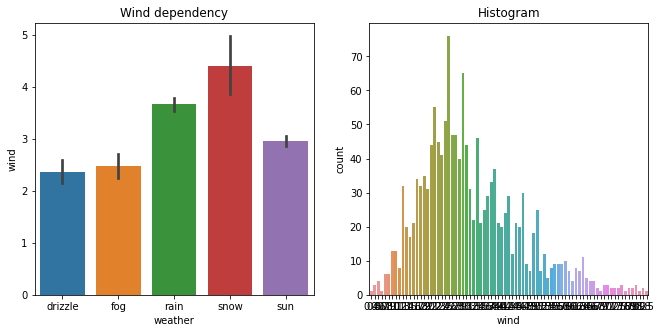

In [14]:
import seaborn as sns

fig, axs = plt.subplots(1,2, figsize=(11, 5))
sns.barplot(data=df, y="wind", x=dep, ax=axs[0]).set(title="Wind dependency")
sns.countplot(data=df, x="wind", ax=axs[1]).set(title="Histogram")

Podemos ver que a velocidade do vento tem pouca variancia entre alguns climas sendo a maior diferença nos climas de chuva e neve

[Text(0.5, 1.0, 'Histogram')]

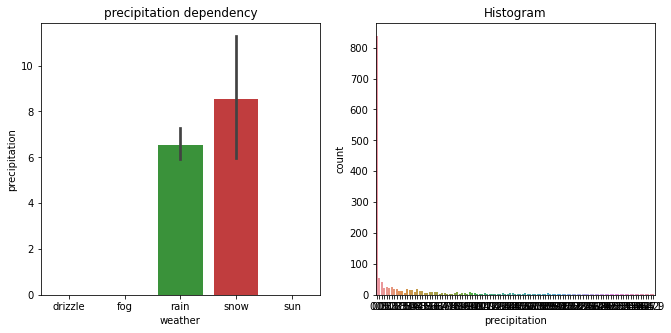

In [15]:
fig, axs = plt.subplots(1,2, figsize=(11, 5))
sns.barplot(data=df, y="precipitation", x=dep, ax=axs[0]).set(title="precipitation dependency")
sns.countplot(data=df, x="precipitation", ax=axs[1]).set(title="Histogram")

<AxesSubplot:>

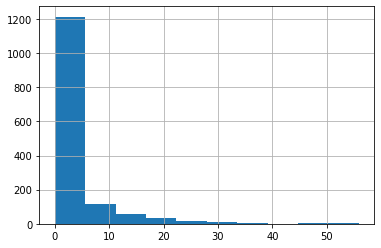

In [16]:
df['precipitation'].hist()

A precipitação expressa uma dependencia maior para com o tempo, sendo que a mesma aparece apenas nos tempos de chuva e neve, tendo uma variação maior no tempo de neve.

Com essa alta dependencia é interessante testar a utilização do modelo tranformando adicionando uma coluna que dirá se está tendo precipitação ou não para ver se o modelo terá um comportamento diferente.

[Text(0.5, 1.0, 'Histogram')]

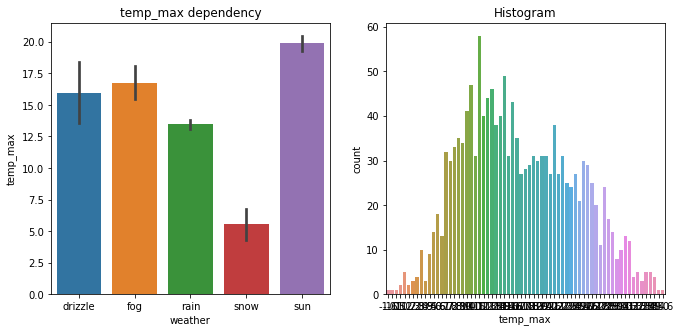

In [17]:
fig, axs = plt.subplots(1,2, figsize=(11, 5))
sns.barplot(data=df, y="temp_max", x=dep, ax=axs[0]).set(title="temp_max dependency")
sns.countplot(data=df, x="temp_max", ax=axs[1]).set(title="Histogram")

podemos ver que a variação da temperatura máxima para com o tempo impactará mais quando estiver nevando onde ela tem uma diferença de 10º para com o clima que tem a temperatura máxima média mais próxima.

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(11, 5))
sns.barplot(data=df, y="temp_min", x=dep, ax=axs[0]).set(title="temp_min dependency")
sns.countplot(data=df, x="temp_min", ax=axs[1]).set(title="Histogram")

A temperatura minima tem o mesmo comportamenta da temperatura máxima, fazendo com que a mudança maior ocorra no tempo de neve

## Treinando o modelo
Assim fazemos a divisão do dataframe de treino e de validação

In [19]:
from numpy import random
from sklearn.model_selection import train_test_split

random.seed(42)
trn_df, val_df = train_test_split(df, test_size=0.25)
trn_df[dep].cat.codes

810     4
1384    4
626     4
813     4
839     2
       ..
1130    2
1294    4
860     2
1459    4
1126    1
Length: 1095, dtype: int8

transformamos o _weather_ em seus códigos

In [20]:
trn_df[dep] = trn_df[dep].cat.codes
val_df[dep] = val_df[dep].cat.codes

fazemos então a divisão do dataframe de treinamento e validação, também encasulando nossa variavel dependente _weather_ que será a mesma predita

In [21]:
def xs_y(df):
    xs = df[cats+conts].copy()
    return xs, df[dep] if dep in df else None

trn_xs, trn_y = xs_y(trn_df)
val_xs, val_y = xs_y(val_df)

calculamos o erro absoluto antes de melhorarmos nosso modelo por meio da biblioteca sklearn

In [22]:
preds = val_xs.precipitation==8

In [23]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(val_y, preds)

2.73224043715847

Para termos uma maior visão de como esta o comportamento das colunas no dataframe de teste, plotamos mais gráficos para um melhor entendimento

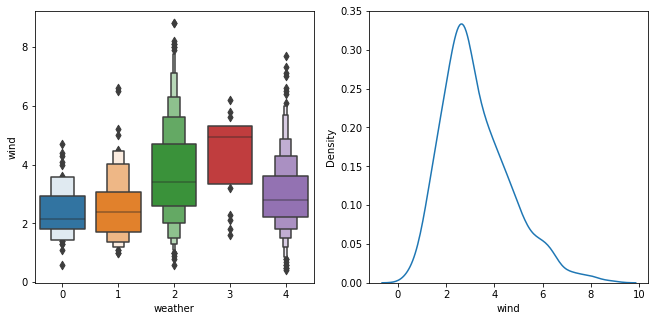

In [24]:
df_wind = trn_df[trn_df.wind > 0]
fig,axs = plt.subplots(1,2, figsize=(11,5))
sns.boxenplot(data=df_wind, x=dep, y="wind", ax=axs[0])
sns.kdeplot(data=df_wind, x="wind", ax=axs[1]);

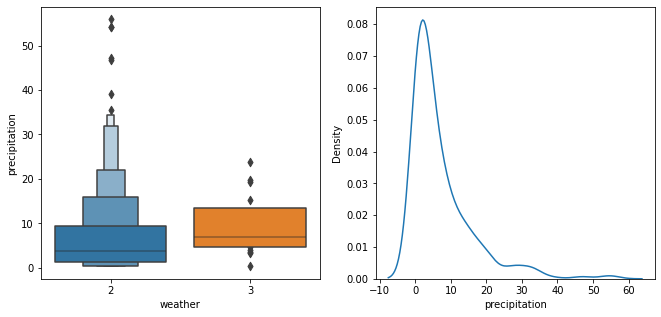

In [25]:
df_precipitation = trn_df[trn_df.precipitation > 0]
fig,axs = plt.subplots(1,2, figsize=(11,5))
sns.boxenplot(data=df_precipitation, x=dep, y="precipitation", ax=axs[0])
sns.kdeplot(data=df_precipitation, x="precipitation", ax=axs[1]);

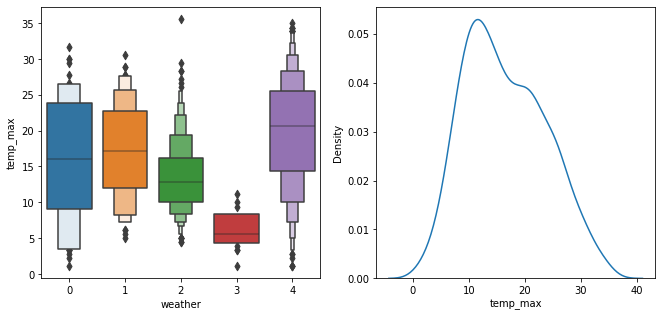

In [26]:
df_temp_max = trn_df[trn_df.temp_max > 0]
fig,axs = plt.subplots(1,2, figsize=(11,5))
sns.boxenplot(data=df_temp_max, x=dep, y="temp_max", ax=axs[0])
sns.kdeplot(data=df_temp_max, x="temp_max", ax=axs[1]);

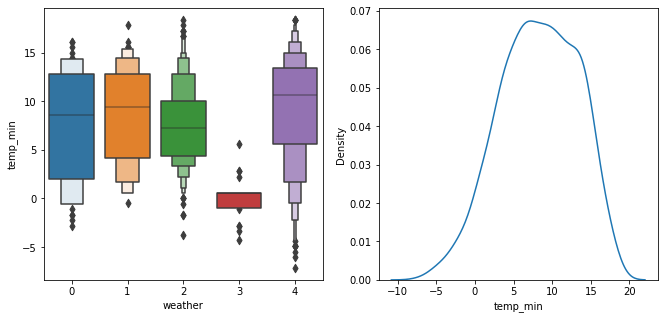

In [27]:
df_temp_min = trn_df[trn_df.temp_min > -10]
fig,axs = plt.subplots(1,2, figsize=(11,5))
sns.boxenplot(data=df_temp_min, x=dep, y="temp_min", ax=axs[0])
sns.kdeplot(data=df_temp_min, x="temp_min", ax=axs[1]);

In [28]:
preds = val_xs.wind>1
mean_absolute_error(val_y, preds)

1.825136612021858

In [29]:
preds = val_xs.precipitation==0
mean_absolute_error(val_y, preds)

2.226775956284153

Assim fazemos uma função que determinará o qual bom está o modelo.

In [30]:
def _side_score(side, y):
    tot = side.sum()
    if tot<=1: return 0
    return y[side].std()*tot

In [31]:
def score(col, y, split):
    lhs = col<=split
    return (_side_score(lhs,y) + _side_score(~lhs,y))/len(y)

In [32]:
score(trn_xs['precipitation'], trn_y, 0.1)

0.8528251032667895

In [33]:
score(trn_xs['wind'], trn_y, 5.0)

1.1858330809577047

para facilitar o processo de achar o melhor _binary split_, podemos criar uma ferramenta de interação 

In [34]:
def iscore(nm, split):
    col = trn_xs[nm]
    return score(col, trn_y, split)

from ipywidgets import interact
interact(nm=conts, split=15.5)(iscore);

interactive(children=(Dropdown(description='nm', options=('precipitation', 'temp_max', 'temp_min', 'wind'), va…

mesmo assim pode ficar trabalhoso achar a melhor, por isso passamos a fazer um programa que definira isso

In [35]:
nm = "temp_max"
col = trn_xs[nm]
unq = col.unique()
unq.sort()
unq

array([-1.6, -1.1, -0.5,  0. ,  1.1,  2.2,  2.8,  3.3,  3.9,  4.4,  5. ,  5.6,  6.1,  6.7,  7.2,  7.8,  8.3,  8.9,  9.4, 10. , 10.6, 11.1,
       11.7, 12.2, 12.8, 13.3, 13.9, 14.4, 15. , 15.6, 16.1, 16.7, 17.2, 17.8, 18.3, 18.9, 19.4, 20. , 20.6, 21.1, 21.7, 22.2, 22.8, 23.3,
       23.9, 24.4, 25. , 25.6, 26.1, 26.7, 27.2, 27.8, 28.3, 28.9, 29.4, 30. , 30.6, 31.1, 31.7, 32.2, 32.8, 33.3, 33.9, 34.4, 35. , 35.6])

In [36]:
scores = np.array([score(col, trn_y, o) for o in unq if not np.isnan(o)])
unq[scores.argmin()]

17.2

In [37]:
def min_col(df, nm):
    col,y = df[nm],df[dep]
    unq = col.dropna().unique()
    scores = np.array([score(col, y, o) for o in unq if not np.isnan(o)])
    idx = scores.argmin()
    return unq[idx],scores[idx]

min_col(trn_df, "temp_max")

(17.2, 1.136568939147715)

In [38]:
cols = conts
{o:min_col(trn_df, o) for o in cols}

{'precipitation': (0.0, 0.8528251032667895),
 'temp_max': (17.2, 1.136568939147715),
 'temp_min': (10.6, 1.1709806860354488),
 'wind': (4.4, 1.1780899515732974)}

De acordo com o esse calculo _precipitation_<=0.8 é o melhor a usar e assim por diante

### Criando as arvores de decisão

a funçaõ `DecisionTreeClassifier` irá realizar a decisão dos valores a definir os _binary splits_

In [39]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

m = DecisionTreeClassifier(max_leaf_nodes=4).fit(trn_xs, trn_y);

para proposito de teste também foi utilizado o `DecisionTreeRegressor`, para ver se usar regressão linear traria um resultado melhor

In [40]:
from sklearn.tree import DecisionTreeRegressor

m2 = DecisionTreeRegressor(max_leaf_nodes=4).fit(trn_xs, trn_y);

Criamos então a função que mostrará as arvores

In [41]:
import graphviz

def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

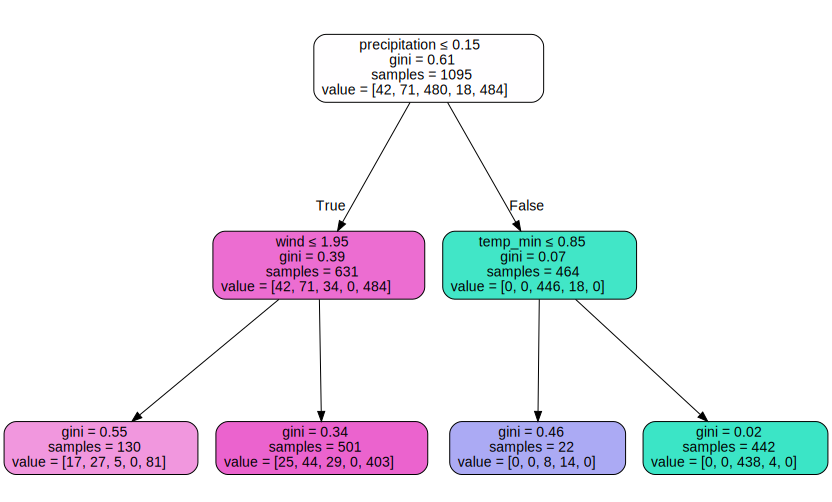

In [42]:
draw_tree(m, trn_xs, size=12)

realizando essa primeira arvore pode-se observar que o modelo ao final separou apenas uma gama de 3 temos possíveis, sendo _sun_, _rain_ e _snow_ este último ocorrendo muito raramente

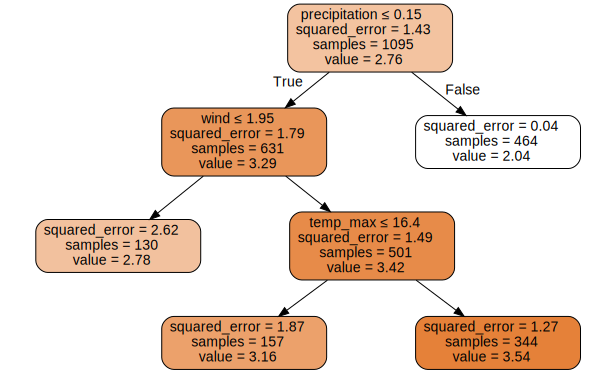

In [43]:
draw_tree(m2, trn_xs, size=12)

utilizando de regressão, também obtemos pouca variação na decisão.

Após isso fazemos a função que decidirá qual o tempo que temos

In [44]:
def gini(cond):
    act = df.loc[cond, dep]
    return act.cat.codes

In [45]:
gini(df.precipitation==0).describe()

count    838.000000
mean       3.280430
std        1.338297
min        0.000000
25%        4.000000
50%        4.000000
75%        4.000000
max        4.000000
dtype: float64

apenas colocando a precipitação como 0 vemos que o modelo mostra uma maioria dos dias sendo de sol

In [46]:
mean_absolute_error(val_y, m.predict(val_xs))

0.4426229508196721

In [47]:
mean_absolute_error(val_y, m2.predict(val_xs))

0.6312622804724565

aqui vemos que ambos os erros absolutos dos tipos de arvores, sendo a `DecisionTreeClassifier` com o erro comparativamente bem menor

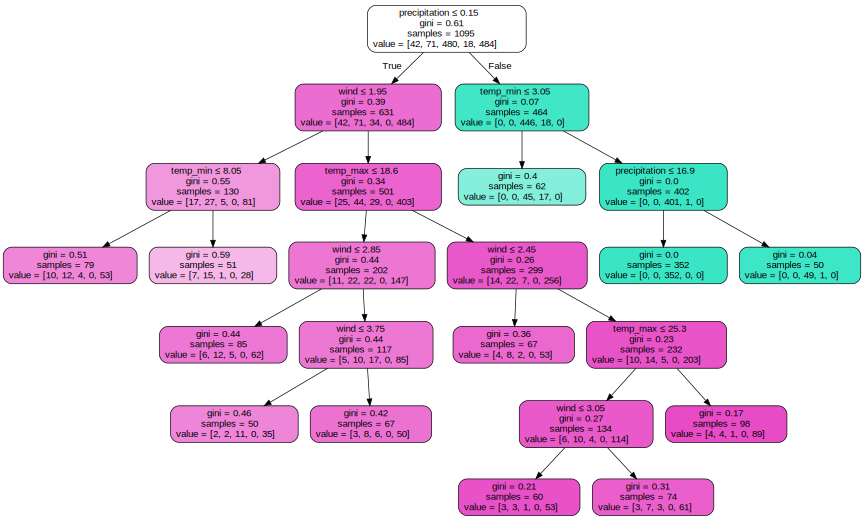

In [48]:
m = DecisionTreeClassifier(min_samples_leaf=50)
m.fit(trn_xs, trn_y)
draw_tree(m, trn_xs, size=12)

mesmo aumentando nossa arvore de decisão, vemos que os resultados continuam os mesmos

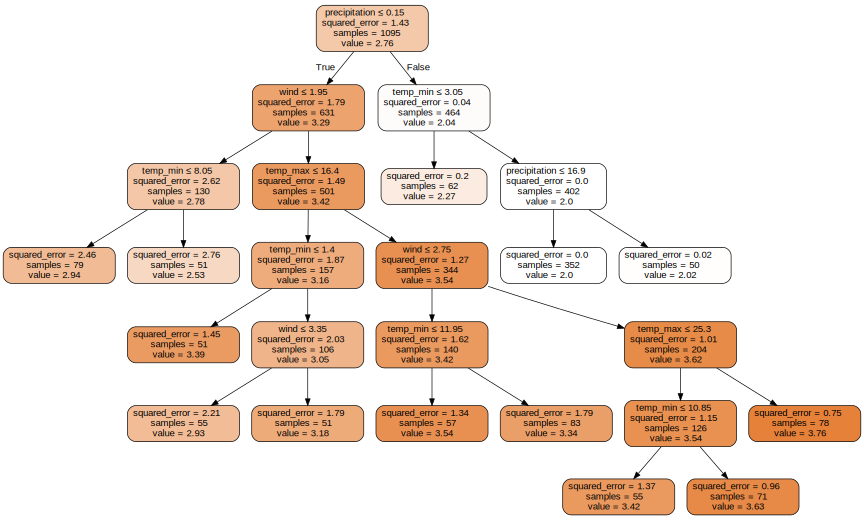

In [49]:
m2 = DecisionTreeRegressor(min_samples_leaf=50)
m2.fit(trn_xs, trn_y)
draw_tree(m2, trn_xs, size=12)

acontecendo o mesmo para com a regressão

In [50]:
mean_absolute_error(val_y, m.predict(val_xs))

0.4426229508196721

In [51]:
mean_absolute_error(val_y, m2.predict(val_xs))

0.6335915090143865

e infelizmente, ambos os erros absolutos continuam os mesmos

## O Random Forest

Infelizmente não podemos deixar nossa arvore maior que os ultimos exemplos mostrados acima, pois a quantidade de amostras por folha chegou a um ponto em que pioraria o desempenho caso diminuissem. Assim tentamos então pegar a médias das previsões para então ter o mais próximo do valor verdadeiro.

e para fazermos isso temos de criar modelos e treina-los com subconjuntos aleatórios dos dados.

In [52]:
def get_tree(prop=0.75):
    n = len(trn_y)
    idxs = random.choice(n, int(n*prop))
    return DecisionTreeClassifier(min_samples_leaf=5).fit(trn_xs.iloc[idxs], trn_y.iloc[idxs])

In [53]:
trees = [get_tree() for t in range(100)]

In [54]:
all_probs = [t.predict(val_xs) for t in trees]
avg_probs = np.stack(all_probs).mean(0)

mean_absolute_error(val_y, avg_probs)

0.5606557377049181

In [55]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(100, min_samples_leaf=5)
rf.fit(trn_xs, trn_y);
mean_absolute_error(val_y, rf.predict(val_xs))

0.4371584699453552

Felizmente conseguimos diminuir ligeiramente o erro, porém não o bastante a ponto de mudar consideravelmente nossas predições.

### Analisando a Dependencia das colunas

Aqui vemos que a precipitação por ter uma variação grande e também por ocorrer em apenas nos tempos de chuva e neve tem grande importancia para com os modelos, tendo uma mudança ligeiramente diferente com o modelo utilizando regressão.

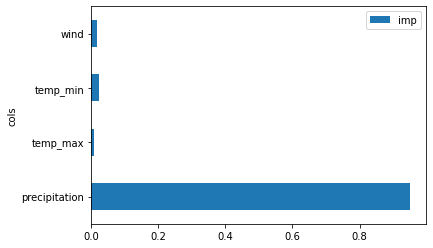

In [56]:
pd.DataFrame(dict(cols=trn_xs.columns, imp=m.feature_importances_)).plot('cols', 'imp', 'barh');

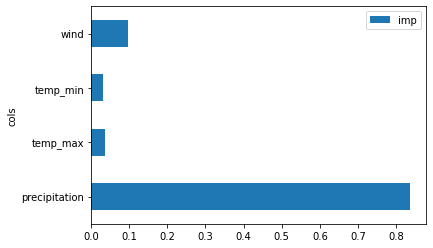

In [57]:
pd.DataFrame(dict(cols=trn_xs.columns, imp=m2.feature_importances_)).plot('cols', 'imp', 'barh');

### Exportando os modelos

In [58]:
import pickle

with open("model.pkl", "wb") as f:
    pickle.dump(m, f)

In [59]:
with open("model2.pkl", "wb") as f:
    pickle.dump(m2, f)

## Conclusão

O deploy do modelo está disponível em: https://huggingface.co/spaces/matheuscvp/predict_weather

Utilizar de Random Forest traz bastantes resultados caso o dataset em questão tenha ao menos uma coluna de caracterização que pode ser traduzida em valores binarios. Outra questão que fez com que o modelo apresentasse resultados com pouca variação é o fato de que no dataset há em sua maioria dias de chuva(_rain_) e sol(_sun_).

E por isso infelizmente, o modelo criado não tem uma boa performance em questão de conseguir predizer todos os 5 tempos possíveis corretamente, acredito que ao adicionar uma coluna para ser categorizada em se está tendo ou não precipitação, poderá melhorar o desempenho dos modelos que utilizam arvores de descisão.

Ao mesmo tempo que pode ser considerado um sucesso caso o objetivo fosse apenas predizer se é um dia de sol ou chuva.